<a href="https://colab.research.google.com/github/akashganesan1/Netflix-Shows-Movies-Genre-Prediction/blob/main/Netflix_genre_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
#@title Libraries
import pandas as pd
import numpy as np
#from google.colab import drive
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score,make_scorer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import absolute
from numpy import sqrt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [63]:
#@title Custom Functions
def missing_values_percentage(dataframe):
    result= (round((dataframe.isnull().sum() * 100/ len(dataframe)),2).sort_values(ascending=False))
    df_missing_values = pd.DataFrame(result,columns=['missing_percentage'])
    df_missing_values.reset_index(inplace=True)
    df_missing_values = df_missing_values.rename(columns = {'index':'column_name'})
    return df_missing_values


def deleting_columns(dataframe1,dataframe2):
    column_list = dataframe2['column_name'].to_numpy()
    for i in column_list:
        dataframe1 = dataframe1.drop([i], axis=1)
    return dataframe1

format_str = '%B %d, %Y'
def process_date_str(date_str):
    try:
        # remove the extra space before the month name
        date_str = date_str.strip()
        
        # parse the date string into a datetime object using the format string
        date_obj = datetime.strptime(date_str, format_str)
        
        # format the datetime object into separate month, day, and year strings
        month = date_obj.strftime('%m')
        day = date_obj.strftime('%d')
        year = date_obj.strftime('%Y')
        
        # return a tuple of (month, day, year)
        return month, day, year
    
    except ValueError:
        # if parsing fails, return a tuple of (None, None, None)
        return None, None, None

In [64]:
#@title Data Loading
url='https://drive.google.com/file/d/1IHDr6R9SBDV8VvCdFCDOfTCaEi2vAAzW/view?usp=share_link'
url1='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url1)
df

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...
...,...,...,...,...,...,...,...,...,...,...,...,...
8802,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,"November 20, 2019",2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a..."
8803,s8804,TV Show,Zombie Dumb,NaN,NaN,NaN,"July 1, 2019",2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g..."
8804,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,"November 1, 2019",2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero..."


# Data Cleaning and Exploration

In [65]:
df['listed_in'] = df['listed_in'].astype(str).str.split(',')
df_temp = pd.DataFrame(df['listed_in'].tolist(), columns=['genre_' + str(i) for i in range(1, df['listed_in'].apply(len).max()+1)])
df = pd.concat([df, df_temp], axis=1)

In [66]:
columns_tobe_deleted = missing_values_percentage(df)
columns_tobe_deleted 

,column_name,missing_percentage
0,genre_3,57.66
1,director,29.91
2,genre_2,22.94
3,country,9.44
4,cast,9.37
5,date_added,0.11
6,rating,0.05
7,duration,0.03
8,show_id,0.00
9,type,0.00


In [67]:
df_missing_values = columns_tobe_deleted [columns_tobe_deleted ['missing_percentage'] > 20.0]
df_missing_values

,column_name,missing_percentage
0,genre_3,57.66
1,director,29.91
2,genre_2,22.94


In [68]:
column_list = df_missing_values['column_name'].to_numpy()
for i in column_list:
  df = df.drop([i], axis=1)

In [69]:
df.shape

(8807, 12)

In [70]:
df = df.applymap(lambda x: x.upper() if type(x) == str else x)

In [71]:
df.head()

,show_id,type,title,cast,country,date_added,release_year,rating,duration,listed_in,description,genre_1
0,S1,MOVIE,DICK JOHNSON IS DEAD,NaN,UNITED STATES,"SEPTEMBER 25, 2021",2020,PG-13,90 MIN,[Documentaries],"AS HER FATHER NEARS THE END OF HIS LIFE, FILMM...",DOCUMENTARIES
1,S2,TV SHOW,BLOOD & WATER,"AMA QAMATA, KHOSI NGEMA, GAIL MABALANE, THABAN...",SOUTH AFRICA,"SEPTEMBER 24, 2021",2021,TV-MA,2 SEASONS,"[International TV Shows, TV Dramas, TV Myste...","AFTER CROSSING PATHS AT A PARTY, A CAPE TOWN T...",INTERNATIONAL TV SHOWS
2,S3,TV SHOW,GANGLANDS,"SAMI BOUAJILA, TRACY GOTOAS, SAMUEL JOUY, NABI...",NaN,"SEPTEMBER 24, 2021",2021,TV-MA,1 SEASON,"[Crime TV Shows, International TV Shows, TV ...",TO PROTECT HIS FAMILY FROM A POWERFUL DRUG LOR...,CRIME TV SHOWS
3,S4,TV SHOW,JAILBIRDS NEW ORLEANS,NaN,NaN,"SEPTEMBER 24, 2021",2021,TV-MA,1 SEASON,"[Docuseries, Reality TV]","FEUDS, FLIRTATIONS AND TOILET TALK GO DOWN AMO...",DOCUSERIES
4,S5,TV SHOW,KOTA FACTORY,"MAYUR MORE, JITENDRA KUMAR, RANJAN RAJ, ALAM K...",INDIA,"SEPTEMBER 24, 2021",2021,TV-MA,2 SEASONS,"[International TV Shows, Romantic TV Shows, ...",IN A CITY OF COACHING CENTERS KNOWN TO TRAIN I...,INTERNATIONAL TV SHOWS


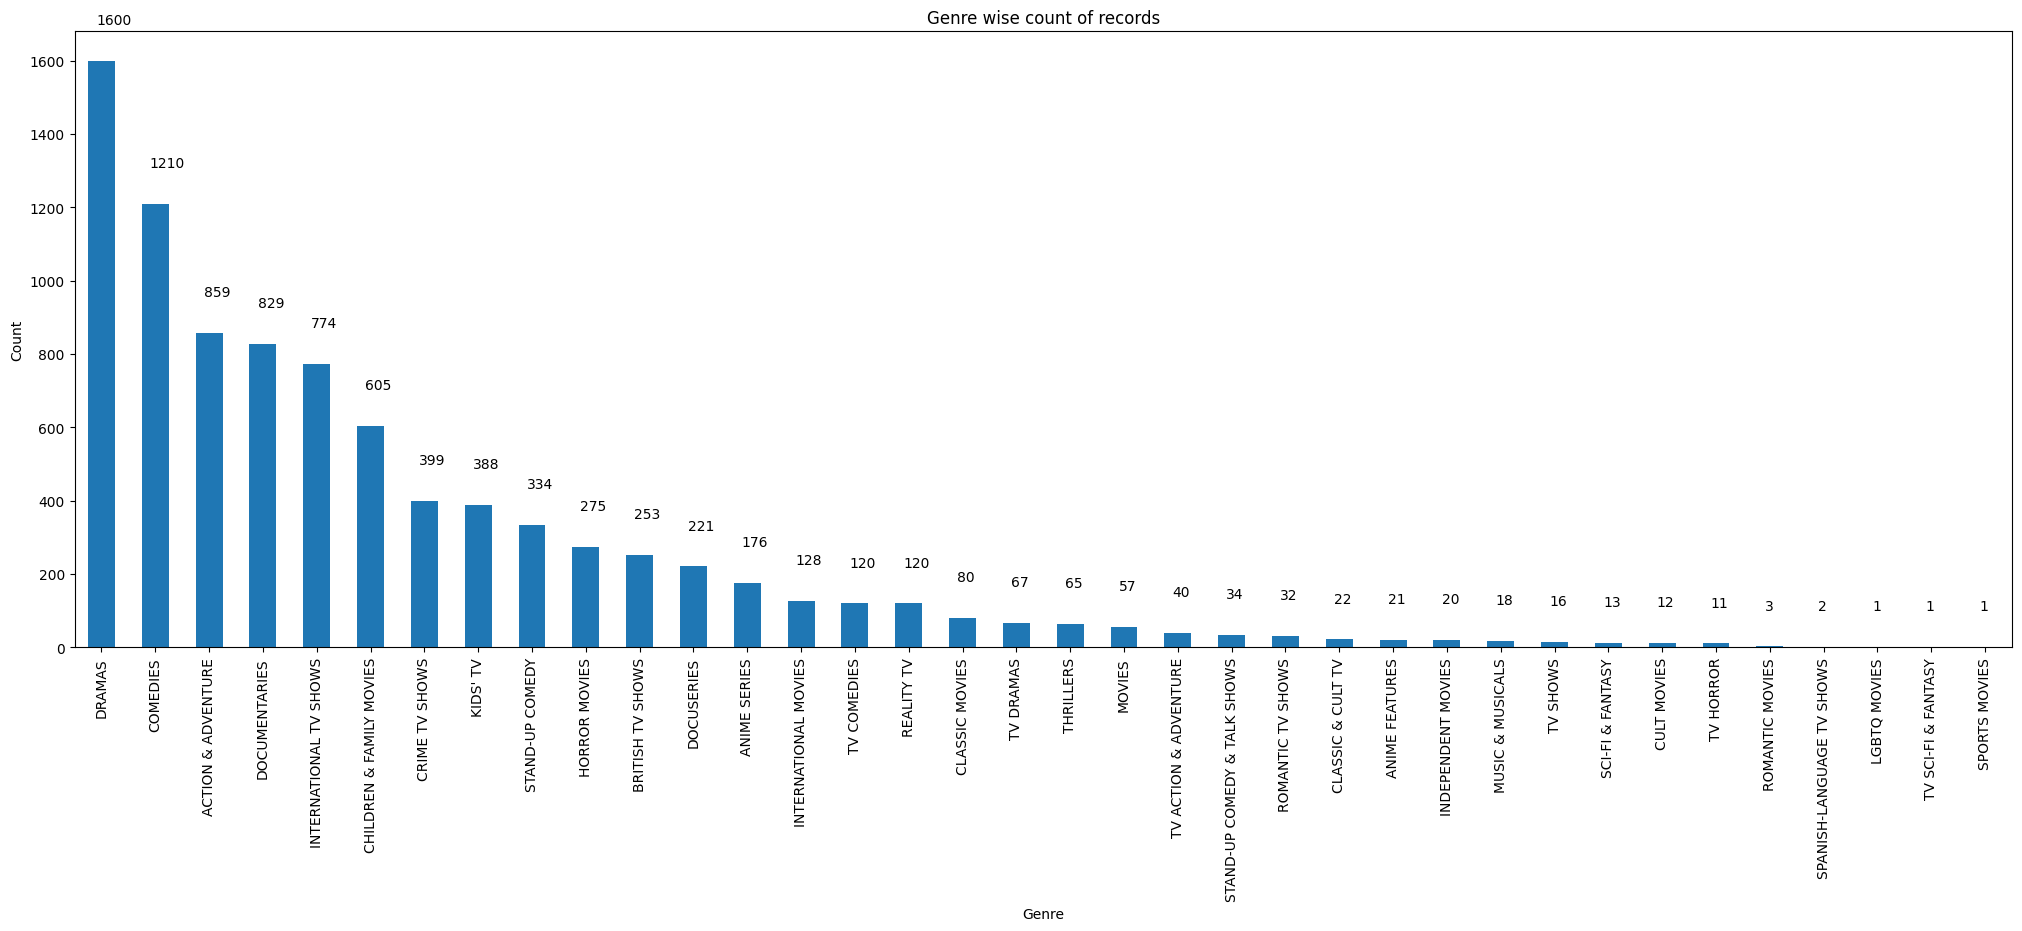

In [72]:
value_counts = df['genre_1'].value_counts()
plt.figure(figsize=(25, 8))
value_counts.plot(kind='bar')
plt.title('Genre wise count of records')
plt.xlabel('Genre')
plt.ylabel('Count')
for i, v in enumerate(value_counts):
    plt.text(i - 0.1, v + 100, str(v))
plt.show()

In [73]:
df['genre_1'].nunique()

36

In [74]:
get_new_genre = lambda val: 'HORROR & THRILLERS' if val in ['HORROR MOVIES', 'CRIME TV SHOWS', 'THRILLERS', 'ROMANTIC MOVIES', 'TV HORROR'] else \
                            'COMEDY' if val in ['COMEDIES','STAND-UP COMEDY','TV COMEDIES','STAND-UP COMEDY & TALK SHOWS'] else \
                            'DRAMAS' if val in ['DRAMAS', 'TV DRAMAS', 'ROMANTIC TV SHOWS', 'ROMANTIC MOVIES'] else \
                            'ACTION & ADVENTURE' if val in ['TV ACTION & ADVENTURE', 'ACTION & ADVENTURE', 'TV SCI-FI & FANTASY', 'SCI-FI & FANTASY', 'SPORTS MOVIES', 'CLASSIC MOVIES', 'CULT MOVIES', 'CLASSIC & CULT TV', 'REALITY TV', 'LGBTQ MOVIES'] else \
                            'ANIME' if val in ['ANIME SERIES', 'ANIME FEATURES', "KIDS' TV", 'MOVIES', 'INDEPENDENT MOVIES', 'TV SHOWS'] else \
                            'DOCUMENTARIES' if val in ['DOCUMENTARIES','DOCUSERIES','SPANISH-LANGUAGE TV SHOWS','BRITISH TV SHOWS'] else \
                            'CHILDREN & FAMILY' if val in ['CHILDREN & FAMILY MOVIES','INTERNATIONAL TV SHOWS','MUSIC & MUSICALS','INTERNATIONAL MOVIES'] else \
                            'OTHER'

In [75]:
df['genre'] = df['genre_1'].apply(get_new_genre)

In [76]:
df['genre'].unique()

array(['DOCUMENTARIES', 'CHILDREN & FAMILY', 'HORROR & THRILLERS',
       'DRAMAS', 'COMEDY', 'ANIME', 'ACTION & ADVENTURE'], dtype=object)

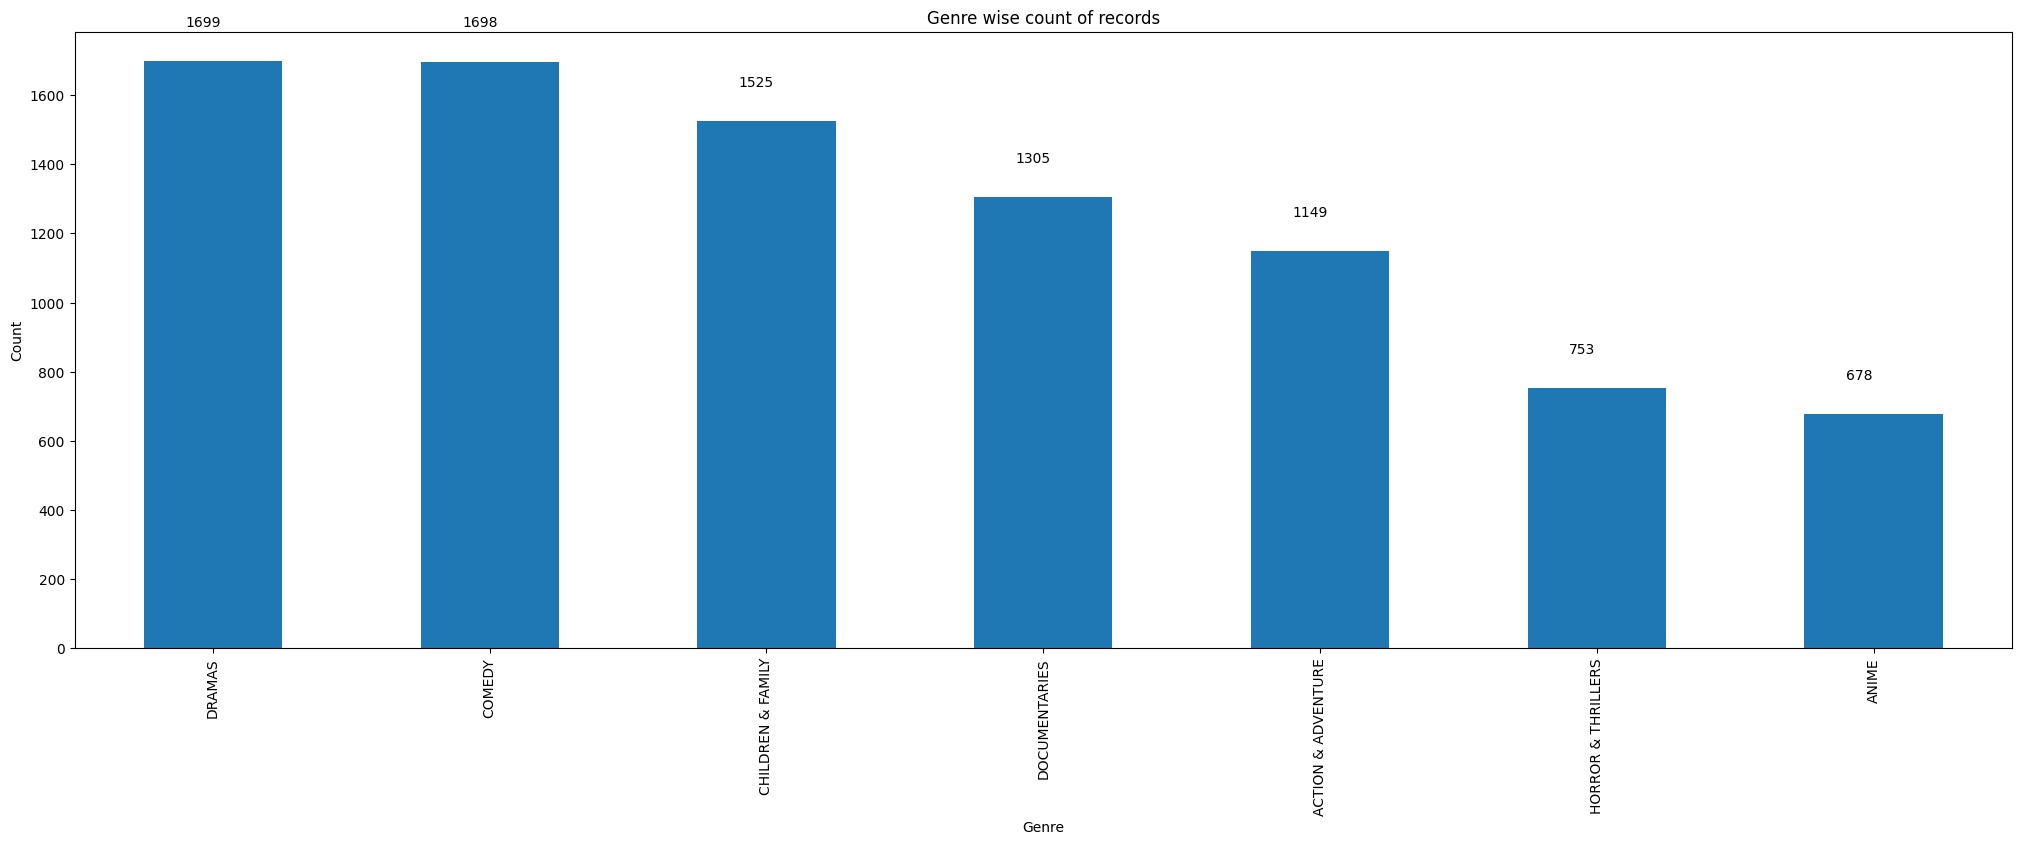

In [77]:
value_counts = df['genre'].value_counts()
plt.figure(figsize=(25, 8))
value_counts.plot(kind='bar')
plt.title('Genre wise count of records')
plt.xlabel('Genre')
plt.ylabel('Count')
for i, v in enumerate(value_counts):
    plt.text(i - 0.1, v + 100, str(v))
plt.show()

In [78]:
df.rename({'genre_1': 'Category'}, axis=1, inplace=True)

In [79]:
df.head()

,show_id,type,title,cast,country,date_added,release_year,rating,duration,listed_in,description,Category,genre
0,S1,MOVIE,DICK JOHNSON IS DEAD,NaN,UNITED STATES,"SEPTEMBER 25, 2021",2020,PG-13,90 MIN,[Documentaries],"AS HER FATHER NEARS THE END OF HIS LIFE, FILMM...",DOCUMENTARIES,DOCUMENTARIES
1,S2,TV SHOW,BLOOD & WATER,"AMA QAMATA, KHOSI NGEMA, GAIL MABALANE, THABAN...",SOUTH AFRICA,"SEPTEMBER 24, 2021",2021,TV-MA,2 SEASONS,"[International TV Shows, TV Dramas, TV Myste...","AFTER CROSSING PATHS AT A PARTY, A CAPE TOWN T...",INTERNATIONAL TV SHOWS,CHILDREN & FAMILY
2,S3,TV SHOW,GANGLANDS,"SAMI BOUAJILA, TRACY GOTOAS, SAMUEL JOUY, NABI...",NaN,"SEPTEMBER 24, 2021",2021,TV-MA,1 SEASON,"[Crime TV Shows, International TV Shows, TV ...",TO PROTECT HIS FAMILY FROM A POWERFUL DRUG LOR...,CRIME TV SHOWS,HORROR & THRILLERS
3,S4,TV SHOW,JAILBIRDS NEW ORLEANS,NaN,NaN,"SEPTEMBER 24, 2021",2021,TV-MA,1 SEASON,"[Docuseries, Reality TV]","FEUDS, FLIRTATIONS AND TOILET TALK GO DOWN AMO...",DOCUSERIES,DOCUMENTARIES
4,S5,TV SHOW,KOTA FACTORY,"MAYUR MORE, JITENDRA KUMAR, RANJAN RAJ, ALAM K...",INDIA,"SEPTEMBER 24, 2021",2021,TV-MA,2 SEASONS,"[International TV Shows, Romantic TV Shows, ...",IN A CITY OF COACHING CENTERS KNOWN TO TRAIN I...,INTERNATIONAL TV SHOWS,CHILDREN & FAMILY


In [80]:
get_age = lambda val: '18+' if val in ['HORROR & THRILLERS'] else \
                            '7+' if val in ['COMEDY'] else \
                            '16+' if val in ['DRAMAS'] else \
                            '16+' if val in ['ACTION & ADVENTURE'] else \
                            '7+' if val in ['ANIME'] else \
                            '13+' if val in ['DOCUMENTARIES'] else \
                            '7+' if val in ['CHILDREN & FAMILY'] else \
                            'OTHER'

In [81]:
df['age'] = df['genre'].apply(get_age)

In [82]:
df.head()

,show_id,type,title,cast,country,date_added,release_year,rating,duration,listed_in,description,Category,genre,age
0,S1,MOVIE,DICK JOHNSON IS DEAD,NaN,UNITED STATES,"SEPTEMBER 25, 2021",2020,PG-13,90 MIN,[Documentaries],"AS HER FATHER NEARS THE END OF HIS LIFE, FILMM...",DOCUMENTARIES,DOCUMENTARIES,13+
1,S2,TV SHOW,BLOOD & WATER,"AMA QAMATA, KHOSI NGEMA, GAIL MABALANE, THABAN...",SOUTH AFRICA,"SEPTEMBER 24, 2021",2021,TV-MA,2 SEASONS,"[International TV Shows, TV Dramas, TV Myste...","AFTER CROSSING PATHS AT A PARTY, A CAPE TOWN T...",INTERNATIONAL TV SHOWS,CHILDREN & FAMILY,7+
2,S3,TV SHOW,GANGLANDS,"SAMI BOUAJILA, TRACY GOTOAS, SAMUEL JOUY, NABI...",NaN,"SEPTEMBER 24, 2021",2021,TV-MA,1 SEASON,"[Crime TV Shows, International TV Shows, TV ...",TO PROTECT HIS FAMILY FROM A POWERFUL DRUG LOR...,CRIME TV SHOWS,HORROR & THRILLERS,18+
3,S4,TV SHOW,JAILBIRDS NEW ORLEANS,NaN,NaN,"SEPTEMBER 24, 2021",2021,TV-MA,1 SEASON,"[Docuseries, Reality TV]","FEUDS, FLIRTATIONS AND TOILET TALK GO DOWN AMO...",DOCUSERIES,DOCUMENTARIES,13+
4,S5,TV SHOW,KOTA FACTORY,"MAYUR MORE, JITENDRA KUMAR, RANJAN RAJ, ALAM K...",INDIA,"SEPTEMBER 24, 2021",2021,TV-MA,2 SEASONS,"[International TV Shows, Romantic TV Shows, ...",IN A CITY OF COACHING CENTERS KNOWN TO TRAIN I...,INTERNATIONAL TV SHOWS,CHILDREN & FAMILY,7+


In [83]:
df['duration'].unique()

array(['90 MIN', '2 SEASONS', '1 SEASON', '91 MIN', '125 MIN',
       '9 SEASONS', '104 MIN', '127 MIN', '4 SEASONS', '67 MIN', '94 MIN',
       '5 SEASONS', '161 MIN', '61 MIN', '166 MIN', '147 MIN', '103 MIN',
       '97 MIN', '106 MIN', '111 MIN', '3 SEASONS', '110 MIN', '105 MIN',
       '96 MIN', '124 MIN', '116 MIN', '98 MIN', '23 MIN', '115 MIN',
       '122 MIN', '99 MIN', '88 MIN', '100 MIN', '6 SEASONS', '102 MIN',
       '93 MIN', '95 MIN', '85 MIN', '83 MIN', '113 MIN', '13 MIN',
       '182 MIN', '48 MIN', '145 MIN', '87 MIN', '92 MIN', '80 MIN',
       '117 MIN', '128 MIN', '119 MIN', '143 MIN', '114 MIN', '118 MIN',
       '108 MIN', '63 MIN', '121 MIN', '142 MIN', '154 MIN', '120 MIN',
       '82 MIN', '109 MIN', '101 MIN', '86 MIN', '229 MIN', '76 MIN',
       '89 MIN', '156 MIN', '112 MIN', '107 MIN', '129 MIN', '135 MIN',
       '136 MIN', '165 MIN', '150 MIN', '133 MIN', '70 MIN', '84 MIN',
       '140 MIN', '78 MIN', '7 SEASONS', '64 MIN', '59 MIN', '139 MIN',
    

In [84]:
get_duration = lambda val: '400 MIN' if val in ['1 SEASON'] else \
                            '800 MIN' if val in ['2 SEASONS'] else \
                            '1200 MIN' if val in ['3 SEASONS'] else \
                            '1600 MIN' if val in ['4 SEASONS'] else \
                            '2000 MIN' if val in ['5 SEASONS'] else \
                            '2400 MIN' if val in ['6 SEASONS'] else \
                            '2800 MIN' if val in ['7 SEASONS'] else \
                            '3200 MIN' if val in ['8 SEASONS'] else \
                            '3600 MIN' if val in ['10 SEASONS'] else \
                            '4000 MIN' if val in ['11 SEASONS'] else \
                            '4400 MIN' if val in ['12 SEASONS'] else \
                            '4800 MIN' if val in ['13 SEASONS'] else \
                            '5200 MIN' if val in ['14 SEASONS'] else \
                            '5600 MIN' if val in ['15 SEASONS'] else \
                            '6000 MIN' if val in ['16 SEASONS'] else \
                            '6400 MIN' if val in ['17 SEASONS'] else  val

In [85]:
df['duration_main'] = df['duration'].apply(get_duration)

In [86]:
df['duration_main'].unique()

array(['90 MIN', '800 MIN', '400 MIN', '91 MIN', '125 MIN', '9 SEASONS',
       '104 MIN', '127 MIN', '1600 MIN', '67 MIN', '94 MIN', '2000 MIN',
       '161 MIN', '61 MIN', '166 MIN', '147 MIN', '103 MIN', '97 MIN',
       '106 MIN', '111 MIN', '1200 MIN', '110 MIN', '105 MIN', '96 MIN',
       '124 MIN', '116 MIN', '98 MIN', '23 MIN', '115 MIN', '122 MIN',
       '99 MIN', '88 MIN', '100 MIN', '2400 MIN', '102 MIN', '93 MIN',
       '95 MIN', '85 MIN', '83 MIN', '113 MIN', '13 MIN', '182 MIN',
       '48 MIN', '145 MIN', '87 MIN', '92 MIN', '80 MIN', '117 MIN',
       '128 MIN', '119 MIN', '143 MIN', '114 MIN', '118 MIN', '108 MIN',
       '63 MIN', '121 MIN', '142 MIN', '154 MIN', '120 MIN', '82 MIN',
       '109 MIN', '101 MIN', '86 MIN', '229 MIN', '76 MIN', '89 MIN',
       '156 MIN', '112 MIN', '107 MIN', '129 MIN', '135 MIN', '136 MIN',
       '165 MIN', '150 MIN', '133 MIN', '70 MIN', '84 MIN', '140 MIN',
       '78 MIN', '2800 MIN', '64 MIN', '59 MIN', '139 MIN', '69 MIN',
  

In [87]:
df[['duration_val', 'duration_unit']] = df['duration_main'].str.split(' ', expand=True)
df['duration_in_mins'] = pd.to_numeric(df['duration_val'])

In [88]:
df = df[['title','Category','genre','rating','date_added','duration','type','duration_in_mins','age']]

In [89]:
df.head()

,title,Category,genre,rating,date_added,duration,type,duration_in_mins,age
0,DICK JOHNSON IS DEAD,DOCUMENTARIES,DOCUMENTARIES,PG-13,"SEPTEMBER 25, 2021",90 MIN,MOVIE,90.0,13+
1,BLOOD & WATER,INTERNATIONAL TV SHOWS,CHILDREN & FAMILY,TV-MA,"SEPTEMBER 24, 2021",2 SEASONS,TV SHOW,800.0,7+
2,GANGLANDS,CRIME TV SHOWS,HORROR & THRILLERS,TV-MA,"SEPTEMBER 24, 2021",1 SEASON,TV SHOW,400.0,18+
3,JAILBIRDS NEW ORLEANS,DOCUSERIES,DOCUMENTARIES,TV-MA,"SEPTEMBER 24, 2021",1 SEASON,TV SHOW,400.0,13+
4,KOTA FACTORY,INTERNATIONAL TV SHOWS,CHILDREN & FAMILY,TV-MA,"SEPTEMBER 24, 2021",2 SEASONS,TV SHOW,800.0,7+


In [90]:
counts = df['rating'].value_counts()

# Filter the dataframe to remove rows with counts less than 200
df = df[df['rating'].isin(counts[counts > 1].index)]

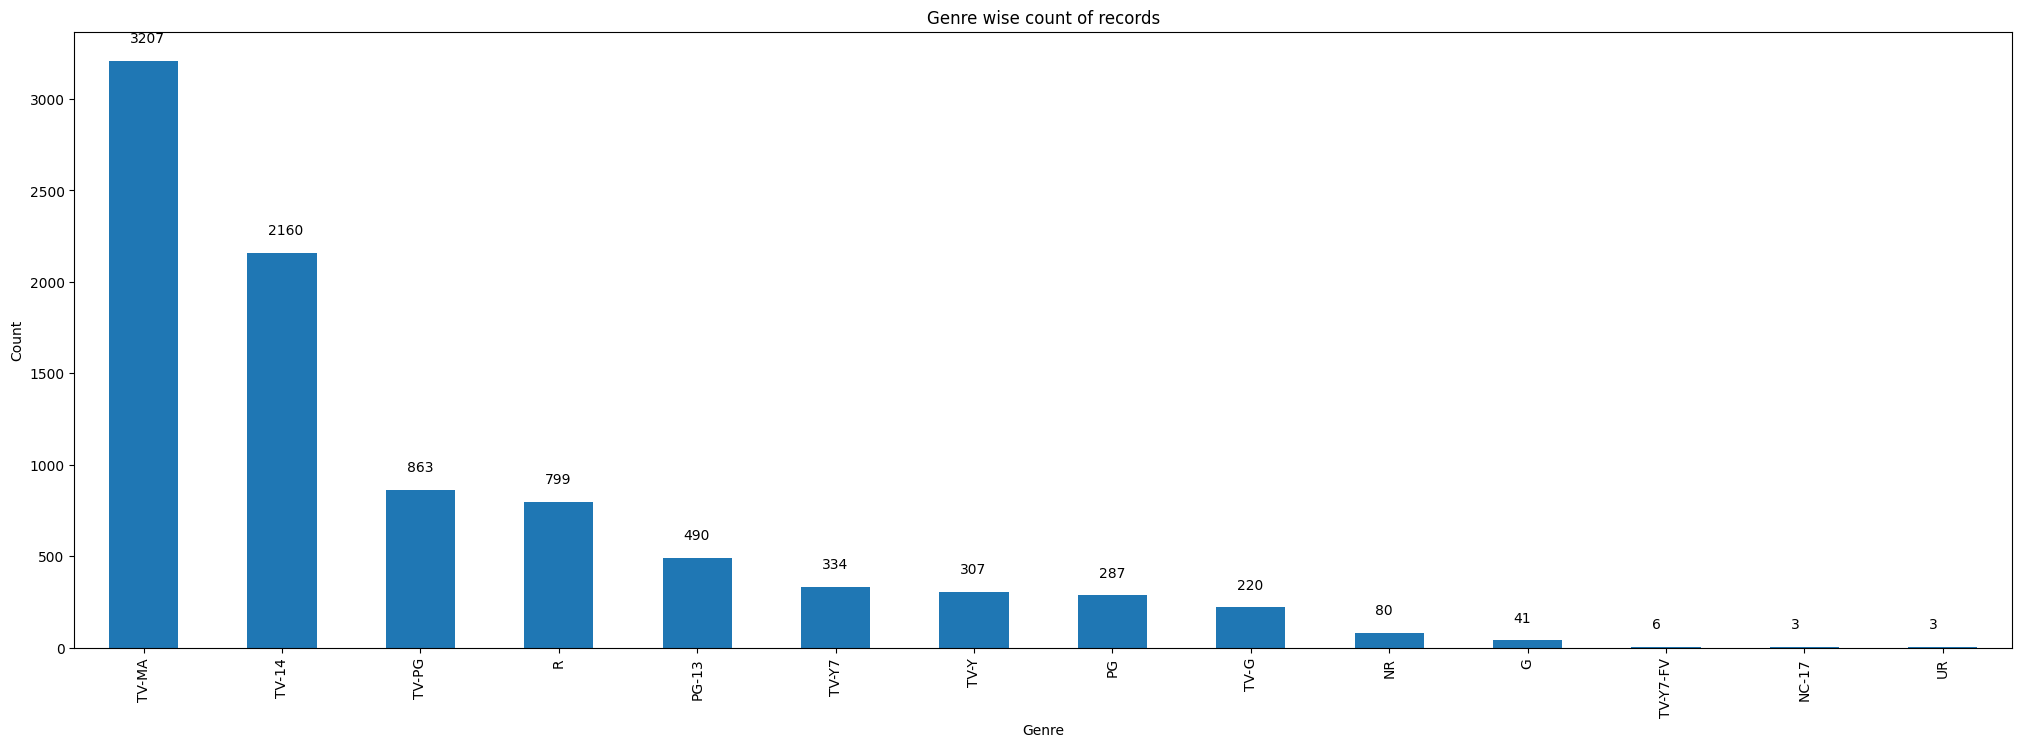

In [91]:
value_counts = df['rating'].value_counts()
plt.figure(figsize=(25, 8))
value_counts.plot(kind='bar')
plt.title('Genre wise count of records')
plt.xlabel('Genre')
plt.ylabel('Count')
for i, v in enumerate(value_counts):
    plt.text(i - 0.1, v + 100, str(v))
plt.show()

In [92]:
df['date_added'] = df['date_added'].str.strip()

In [93]:
df['date_added'] = pd.to_datetime(df['date_added'], format='%B %d, %Y')

In [94]:
df['day'] = df['date_added'].dt.day
df['month'] = df['date_added'].dt.month
df['year'] = df['date_added'].dt.year

In [95]:
missing_values_percentage(df)

,column_name,missing_percentage
0,date_added,0.11
1,day,0.11
2,month,0.11
3,year,0.11
4,title,0.00
5,Category,0.00
6,genre,0.00
7,rating,0.00
8,duration,0.00
9,type,0.00


In [96]:
df=df.dropna().reset_index(drop=True)

In [97]:
df = df.astype({"day":"int","month":"int","year":"int"})

In [98]:
df.head()

,title,Category,genre,rating,date_added,duration,type,duration_in_mins,age,day,month,year
0,DICK JOHNSON IS DEAD,DOCUMENTARIES,DOCUMENTARIES,PG-13,2021-09-25,90 MIN,MOVIE,90.0,13+,25,9,2021
1,BLOOD & WATER,INTERNATIONAL TV SHOWS,CHILDREN & FAMILY,TV-MA,2021-09-24,2 SEASONS,TV SHOW,800.0,7+,24,9,2021
2,GANGLANDS,CRIME TV SHOWS,HORROR & THRILLERS,TV-MA,2021-09-24,1 SEASON,TV SHOW,400.0,18+,24,9,2021
3,JAILBIRDS NEW ORLEANS,DOCUSERIES,DOCUMENTARIES,TV-MA,2021-09-24,1 SEASON,TV SHOW,400.0,13+,24,9,2021
4,KOTA FACTORY,INTERNATIONAL TV SHOWS,CHILDREN & FAMILY,TV-MA,2021-09-24,2 SEASONS,TV SHOW,800.0,7+,24,9,2021


In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8790 entries, 0 to 8789
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   title             8790 non-null   object        
 1   Category          8790 non-null   object        
 2   genre             8790 non-null   object        
 3   rating            8790 non-null   object        
 4   date_added        8790 non-null   datetime64[ns]
 5   duration          8790 non-null   object        
 6   type              8790 non-null   object        
 7   duration_in_mins  8790 non-null   float64       
 8   age               8790 non-null   object        
 9   day               8790 non-null   int32         
 10  month             8790 non-null   int32         
 11  year              8790 non-null   int32         
dtypes: datetime64[ns](1), float64(1), int32(3), object(7)
memory usage: 721.2+ KB


# New Section

In [100]:
df = df.drop(['title'], axis=1)
df = df.drop(['duration'], axis=1)

In [101]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
columns = [
 'Category',
 'rating',
 'day',
 'month',
 'year',
 'duration_in_mins',
 'age',
 'genre']
for col in columns:
    df[col] = le.fit_transform(df[col])

C:\Users\mraka\AppData\Local\Temp\ipykernel_3936\1395503371.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = df.corr()


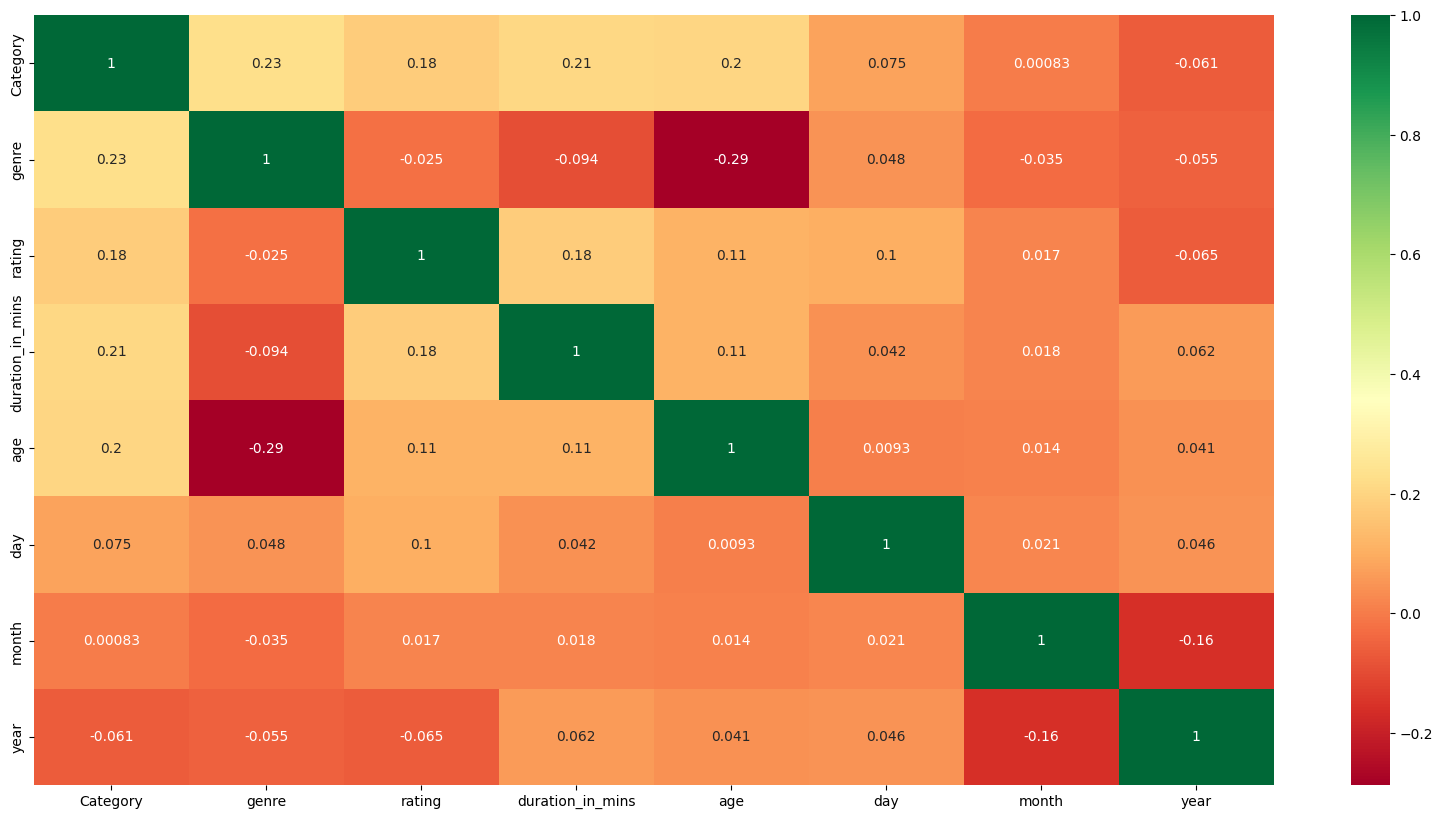

In [102]:
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,10))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8790 entries, 0 to 8789
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Category          8790 non-null   int32         
 1   genre             8790 non-null   int32         
 2   rating            8790 non-null   int32         
 3   date_added        8790 non-null   datetime64[ns]
 4   type              8790 non-null   object        
 5   duration_in_mins  8790 non-null   int64         
 6   age               8790 non-null   int32         
 7   day               8790 non-null   int64         
 8   month             8790 non-null   int64         
 9   year              8790 non-null   int64         
dtypes: datetime64[ns](1), int32(4), int64(4), object(1)
memory usage: 549.5+ KB


In [104]:
df = df.dropna(subset=['date_added'])
df = df.reset_index(drop=True)

In [105]:
list(df.columns)

['Category',
 'genre',
 'rating',
 'date_added',
 'type',
 'duration_in_mins',
 'age',
 'day',
 'month',
 'year']

In [106]:
X1 = df[[
 
 'rating',
 'duration_in_mins',
 'age',
 'day','month','year']]

In [107]:
Y = df['genre']

In [108]:
#X1_train, X1_test, y_train, y_test = train_test_split(X1, Y, test_size = 0.20)

cv = KFold(n_splits=10, random_state=1, shuffle=True)
model = RandomForestClassifier()  
scores = cross_val_score(model, X1, Y, scoring='neg_mean_absolute_error',cv=cv, n_jobs=-1)
#view MAE
mean(absolute(scores))

0.6497155858930602

In [109]:
cv = KFold(n_splits=5, random_state=1, shuffle=True) 
scores = cross_val_score(model, X1, Y, scoring='neg_mean_squared_error',
                         cv=cv, n_jobs=-1)

#view RMSE
sqrt(mean(absolute(scores)))

1.6973512122293453

In [110]:
X1_train, X1_test, y_train, y_test = train_test_split(X1, Y, test_size = 0.20)

In [111]:
clf = RandomForestClassifier(n_estimators = 100)  
  
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(X1_train, y_train)
  
# performing predictions on the test dataset
y_pred = clf.predict(X1_test)
  
# metrics are used to find accuracy or error
from sklearn import metrics  
print()
  
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))
print("r2_score OF THE MODEL: ", metrics.r2_score(y_test,y_pred))


ACCURACY OF THE MODEL:  0.7997724687144482
r2_score OF THE MODEL:  0.07713908231489164


In [112]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import tree
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X1_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X1_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7605233219567691


In [115]:
RandomForest =  RandomForestClassifier()
DecisionTeree  = DecisionTreeClassifier()
Logisticreg = LogisticRegression()
SVM =  SVC()
KNN = KNeighborsClassifier()

In [116]:
model = [RandomForest,DecisionTeree,Logisticreg,SVM,KNN]

for i in range (0,len(model)):
    print(model[i])
    model[i] =model[i].fit(X1_train,y_train)
    y_pred = model[i].predict(X1_test)
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


RandomForestClassifier()
Accuracy: 0.7986348122866894
DecisionTreeClassifier()
Accuracy: 0.7610921501706485
LogisticRegression()
Accuracy: 0.5574516496018203
SVC()


c:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.4055745164960182
KNeighborsClassifier()
Accuracy: 0.4943117178612059
